## Experiments


### General Imports and Functions 

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from policyiter import evaluation, improvement, treebuilder, config
from tqdm import tqdm

In [4]:
def create_random_policy(pre_decision_states, post_decision_states):
    """
    Method to create a random Policy
    :param pre_decision_states: Pre-Decision states represented by an array
    :param post_decision_states: Post-Decision states represented by an array
    :return: policy represented by an array (indecis: Pre-Decision states, values: Post-Decision states)
    """
    # Number of pre decision states to iterate over
    n_pre_states = len(pre_decision_states)

    # initialize policy
    policy = [None] * n_pre_states

    counter = 0

    for pre_state in range(0, n_pre_states):

        # Last States have an empty trans_mat because the time horizon is reached and no decision can be made
        if (pre_decision_states[pre_state]["trans_mat"] is not None):
            random.seed(config.SEED)
            random_state = random.choice(pre_decision_states[pre_state]["trans_mat"].columns.levels[0])
            price_index = pre_decision_states[pre_state]["trans_mat"].index[0]

            policy[pre_state] = pre_decision_states[pre_state]["trans_mat"].loc[price_index][random_state]\
            .iloc[0][0]["post_state"]

    return policy



### State Space Evolution

In [1]:
def build_tree(PRICE_MIN, PRICE_MAX, PRICE_STEP_SIZE, ENERGY_MIN, ENERGY_MAX, ENERGY_STEP_SIZE, EFF_COEFF, 
               MAX_PULL, MAX_PUSH, MAX_TIME, INITIAL_STATE):

    # Definition of possible Price levels
    price_levels = np.arange(PRICE_MIN, PRICE_MAX + PRICE_STEP_SIZE, PRICE_STEP_SIZE)

    # Definition of possible Energy levels
    energy_levels = np.arange(ENERGY_MIN, ENERGY_MAX + ENERGY_STEP_SIZE, ENERGY_STEP_SIZE)

    time_horizon = np.arange(1, MAX_TIME + 1)

    pre_decision_states = []
    post_decision_states = []

    pre_decision_states.append({"v": None, "state": INITIAL_STATE, "trans_mat": None})

    # Create the tree
    start_time_tree = time.process_time()
    pre_decision_states, post_decision_states = treebuilder.create_tree(time_horizon,
                                                                        energy_levels,
                                                                        price_levels,
                                                                        pre_decision_states,
                                                                        post_decision_states,
                                                                        MAX_PULL,
                                                                        MAX_PUSH, 0)
    stop_time_tree = time.process_time()

    time_tree = stop_time_tree - start_time_tree

    # returns 1. #pre_decision_states, 2. #post_decision_states, 3. #price_levels, 4. #energy_levels, 
    # 5. Time time_tree
    return(len(pre_decision_states), len(post_decision_states), len(price_levels), len(energy_levels), time_tree)




### Plot State Space growth

#### Initial Parameters

In [6]:
# DEFINITION OF PRICE LEVELS (DISCRETIZATION CAN BE MODIFIED WITH THE STEP SIZE)
PRICE_MIN = 1
PRICE_MAX = 2
PRICE_STEP_SIZE = 1

# DEFINITION OF ENERGY LEVELS (DISCRETIZATION CAN BE MODIFIED WITH THE STEP SIZE)
ENERGY_MIN = 0
ENERGY_MAX = 4
ENERGY_STEP_SIZE = 1

# MAXIMUM TIME STEPS (MUST BE A NATURAL NUMBER GREATER THEN 0)
MAX_TIME = 2

# Initialize state
# Definition of states: [Price, Energy-Level]
INITIAL_STATE = [1, 0]

# Set a seed for the random policy creation
SEED = 42

# EFFICENCY COEFFICIENT MUST BE BETWEEN 0 AND 1
EFF_COEFF = 0.9

MAX_PULL = 100

MAX_PUSH = 100


#### Regarding Energy Levels

In [18]:
experiment_range = range(1,40,1)
experiment_time = []
amount_pre_states = []
amount_rel_diff_pre = []
amount_post_states = []
amount_rel_diff_post = []
experiment_rel_diff_time = []

for i in tqdm(experiment_range):
    ENERGY_MIN = 0
    ENERGY_MAX = i
    
    pre_states, post_states, _, _, time_tree = build_tree(PRICE_MIN, PRICE_MAX, 
                                                          PRICE_STEP_SIZE, ENERGY_MIN, 
                                                          ENERGY_MAX, ENERGY_STEP_SIZE, EFF_COEFF, 
                                                          MAX_PULL, MAX_PUSH, MAX_TIME, 
                                                          INITIAL_STATE)
    
    
    if(len(amount_rel_diff_pre)==0):
        amount_rel_diff_pre.append(0)
        amount_rel_diff_post.append(0)
        experiment_rel_diff_time.append(0)
    else:
        # calc rel difference in comparison to last state space size
        rel_diff_pre = 1+((pre_states - amount_pre_states[-1]) / amount_pre_states[-1])
        amount_rel_diff_pre.append(rel_diff_pre)
        
        rel_diff_post = 1+((post_states - amount_post_states[-1]) / amount_post_states[-1])
        amount_rel_diff_post.append(rel_diff_post)
        
        rel_diff_time = 1+((time_tree - experiment_time[-1]) / experiment_time[-1])
        experiment_rel_diff_time.append(rel_diff_time)
        
    amount_pre_states.append(pre_states)
    amount_post_states.append(post_states)
    experiment_time.append(time_tree)
    

100%|██████████| 39/39 [02:46<00:00,  9.89s/it]


### Amount of Pre-Decision States

Absolute Numbers:

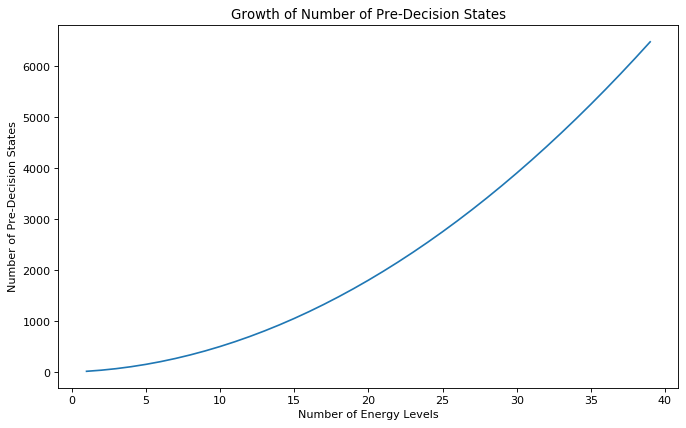

In [19]:
file_name = "absPreStatesEnergyLevels_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_pre_states)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Number of Pre-Decision States")
plt.title("Growth of Number of Pre-Decision States")
plt.savefig('results/'+ file_name +'.png')

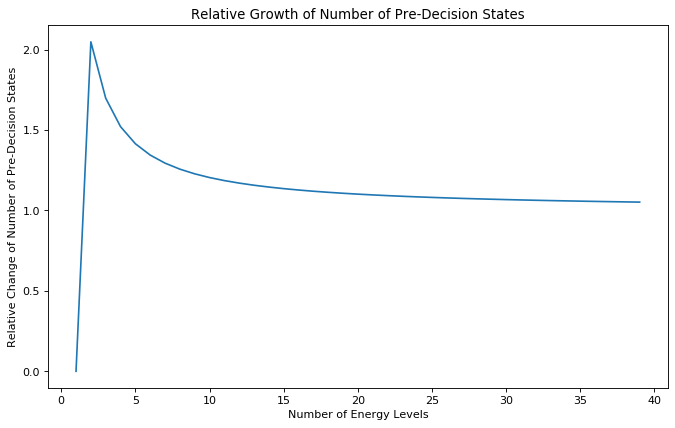

In [20]:
file_name = "relPreStatesEnergyLevels_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_rel_diff_pre)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Relative Change of Number of Pre-Decision States")
plt.title("Relative Growth of Number of Pre-Decision States")
plt.savefig('results/'+ file_name +'.png')

### Amount of Post-Decision States

Absolute Numbers:

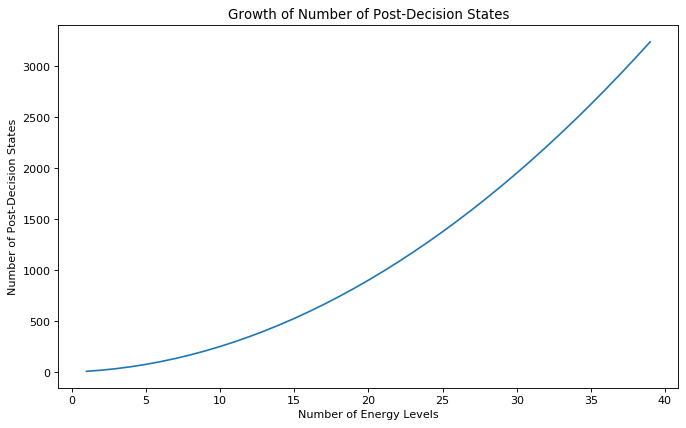

In [21]:
file_name = "absPostStatesEnergyLevels_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_post_states)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Number of Post-Decision States")
plt.title("Growth of Number of Post-Decision States")
plt.savefig('results/'+ file_name +'.png')

Relative Numbers:

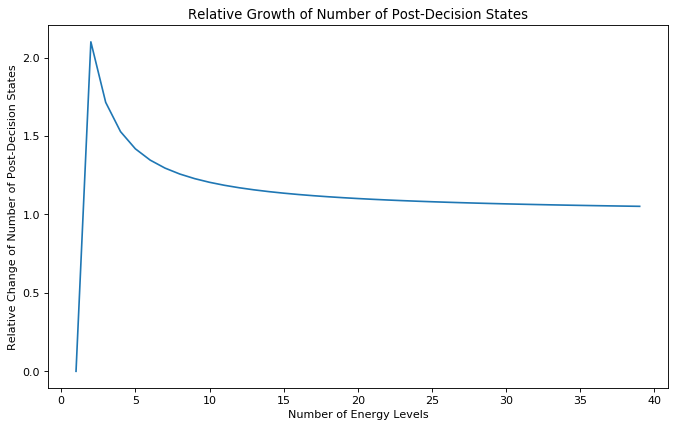

In [22]:
file_name = "relPostStatesEnergyLevels_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_rel_diff_post)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Relative Change of Number of Post-Decision States")
plt.title("Relative Growth of Number of Post-Decision States")
plt.savefig('results/'+ file_name +'.png')

### Time necessary to comput Tree

Absolute Numbers:

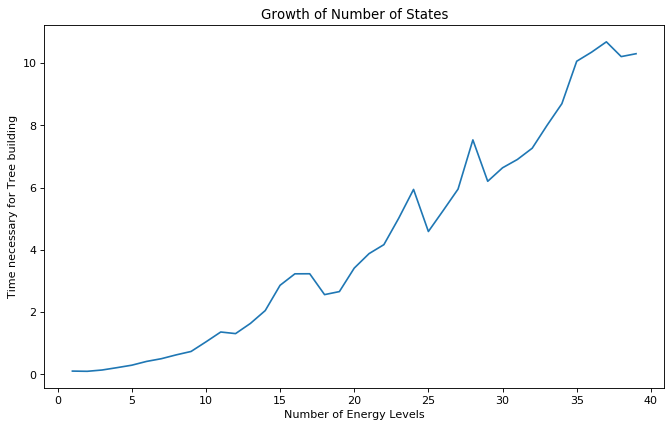

In [23]:
file_name = "absTimeTreeBuilding_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, experiment_time)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Time necessary for Tree building")
plt.title("Growth of Number of States")
plt.savefig('results/'+ file_name +'.png')

Relative Numbers:

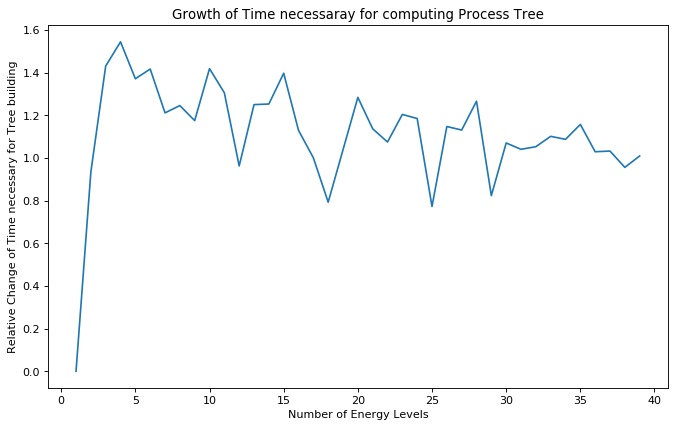

In [24]:
file_name = "relTimeTreeBuilding_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, experiment_rel_diff_time)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Relative Change of Time necessary for Tree building")
plt.title("Growth of Time necessaray for computing Process Tree")
plt.savefig('results/'+ file_name +'.png')

### Plot in one Graph

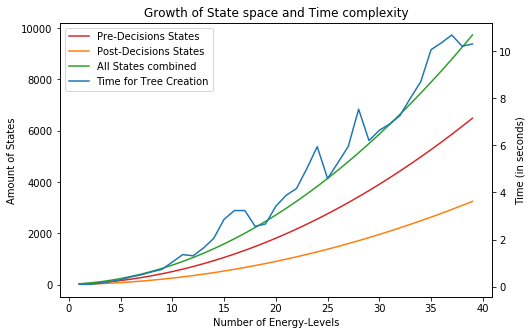

In [57]:
# Create some mock data
t = np.arange(0, 10.0, 1)
data1 = experiment_time
data2 = amount_pre_states

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Energy-Levels')
ax1.set_ylabel('Amount of States', color='black')
pre, = ax1.plot(experiment_range, data2, color=color, label='Pre-Decisions States')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time (in seconds)', color='black')  # we already handled the x-label with ax1
time, = ax2.plot(experiment_range, data1, color=color, label='Time for Tree Creation')
ax2.tick_params(axis='y', labelcolor='black')

color = 'tab:orange'
post, = ax1.plot(experiment_range, amount_post_states, color=color, label='Post-Decisions States')

color = 'tab:green'
both, = ax1.plot(experiment_range, np.sum([amount_pre_states, amount_post_states], axis=0), color=color, label='All States combined')

plt.legend(handles=[pre, post , both, time])
plt.title("Growth of State space and Time complexity")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(5)
fig.set_figwidth(8)

# Save File
file_name = "combinationPlot_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.savefig('results/'+ file_name +'.png')

plt.show()

### Test

In [ ]:
1,0.75, 0.74, 9.063804679
2,1.0, 0.98, 508.312027037
3,1.0, 0.97, 4121.768893175
4,1.0, 0.96, 11850.838561924998
5,1.0, 0.95, 26830.889291422
6,1.0, 0.94, 51192.978600687995

In [10]:
e_levels = [1,2,3,4,5,6]
v_values = [0.75, 1, 1, 1, 1, 1]
profit = [0.74, 0.98,0.97,0.96,0.95,0.94]
time_values = [9.063804679, 508.312027037, 4121.768893175, 11850.838561924998, 26830.889291422, 51192.978600687995]
time_values[:] = [x * (1/60) for x in time_values]

df = pd.DataFrame()
df["e_levels"] = e_levels
df["v_values"] = v_values
df["profit"] = profit
df["time_values"] = time_values

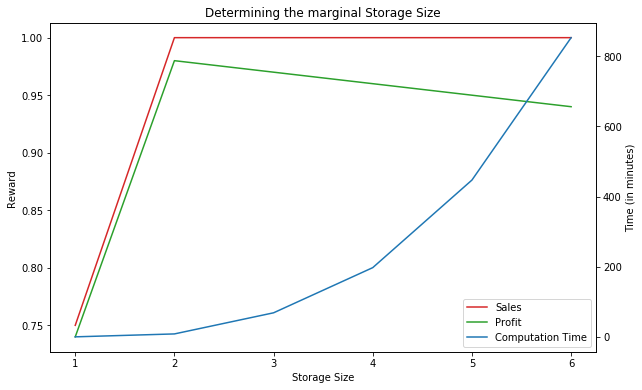

In [18]:
# Create some mock data
t = np.arange(0, 10.0, 1)
data1 = df["time_values"]
data2 = df["v_values"] 
data3 = df["profit"]
experiment_range = df["e_levels"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Storage Size')
ax1.set_ylabel('Reward', color='black')
pre, = ax1.plot(experiment_range, data2, color=color, label='Sales')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time (in minutes)', color='black')  # we already handled the x-label with ax1
time, = ax2.plot(experiment_range, data1, color=color, label='Computation Time')
ax2.tick_params(axis='y', labelcolor='black')

color = 'tab:green'
post, = ax1.plot(experiment_range, data3, color=color, label='Profit')

plt.legend(handles=[pre, post, time], loc=4)
plt.title("Determining the marginal Storage Size")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(6)
fig.set_figwidth(10)

# Save File
file_name = "marginalStorageSize_Pull_2_Push_2_Time_4_n_7_Prob2_0_5_EFF_1" 
plt.savefig('results/'+ file_name +'.png')

plt.show()

### Evaluation of Policy Improvement

In [ ]:
[-4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -4.285714285714286, -1.4285714285714286]","[0, 1, 2, 3, 4, 5]","[57.391321096, 57.96033460700001, 55.392560470999996, 57.158477463000025, 54.073766894000016, 54.95329562300003]","[0, 1.5408074750000083, 1.3873463679999816, 1.385163446000007, 1.370319158999962, 1.3689477679999982]"
